In [3]:
import bionetgen
import numpy as np
import matplotlib.pyplot as plt
import roadrunner as rr

## Load model and setup simulator

In [4]:

model= "updatedSOSRasModel"
model = bionetgen.bngmodel(model + ".bngl") # generates BNG-XML and reads it
sim = model.setup_simulator() # sim is a libroadrunner simulator object
#sim = rr.RoadRunner(model+'_sbml.xml')
sim.setIntegrator('gillespie')
#obs= ['totalRasGTP']
#sim.timeCourseSelections = ['time']+obs

BNGModelError: There was an issue with BNGL model: updatedSOSRasModel.bngl
XML file couldn't be generated

Parameters from paper (bimodality observed):

    Kon1 7e-8 * RhoSOS  #sos binding to RasGDP 

    Kon2 7e-8 * RhoSOS  #sos binding to RasGTP 

    Koff1 5e-3 #sos dissociating from RasGDP #koff1

    Koff2 5e-4 #5e-4 #sos dissociating from RasGTP #koff2

    Kcat1 1e-2 / A #RasGDP to RasGTP # phos
    
    Kcat2 2.5e-3





## Plot Timecourse 

1.0 7e-08
2.0 1.4e-07
3.0 2.1e-07
4.0 2.8e-07
5.0 3.5000000000000004e-07
6.0 4.2e-07
7.0 4.900000000000001e-07
8.0 5.6e-07
9.0 6.3e-07
10.0 7.000000000000001e-07


Text(0, 0.5, 'counts')

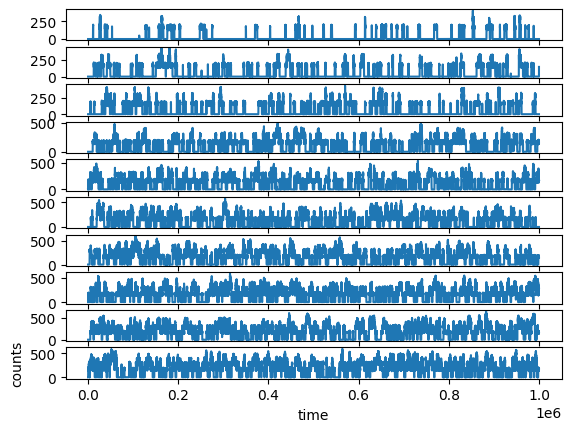

In [ ]:

## Run time course trajectories 

snames=['totalRasGTP','totalBoundRas','TotalRas'] # keep track of observables 
pval= np.linspace(1,10,10) # set range 1 to 10 to iterate through 
traj=[0]*len(pval) 


# for altering the parameters in the model to observe multimodality , comment out if not 
sim.Kcat2=2.5e-2 
sim.Koff1=1e-4

Kon= 7e-8 

for i, p in enumerate(pval):
    sim.RhoSOS= p
    sim.Kon1= p*Kon  # manually update Kon1 and Kon2 values 
    sim.Kon2= p*Kon 
    sim.reset()
    print(sim.RhoSOS,sim.Kon1)
    traj[i]= sim.simulate(0,1000000,1000000)

# plot trajectories
fig, axes = plt.subplots(nrows=len(pval), ncols=1, sharex=True) #, figsize=(4, 12))
for i in range(len(traj)):
    axes[i].plot(traj[i]['time'],traj[i][snames[0]])
axes[-1].set_xlabel('time')
axes[-1].set_ylabel('counts')
#plt.tight_layout()



## Plot Activated RasGTP

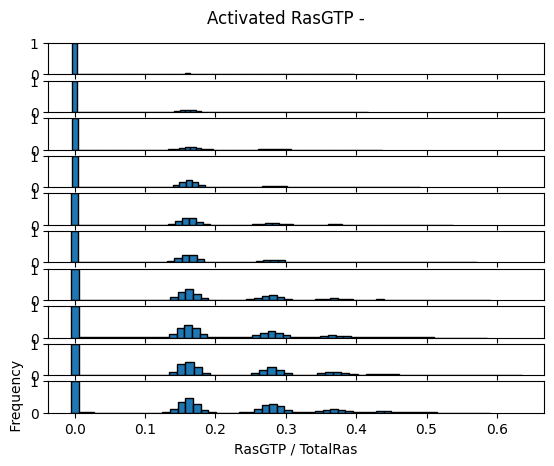

In [ ]:
# plot Activated RasGTP  as ratio of totalRasGTP/totalRas 

fig, axes = plt.subplots(nrows=len(pval), ncols=1, sharex=True)

for i in range(len(traj)):
    total_ras_gtp = traj[i][snames[0]]  # 'totalRasGTP'
    total_ras = traj[i][snames[2]]      # 'TotalRas'
    activated_ras_gtp = total_ras_gtp / total_ras  

    # make histogram
    n, bins = np.histogram(activated_ras_gtp, bins=55)
    
    # normalize so max height is 1
    normalized_values = n / np.max(n)  
    
    bar_width = np.diff(bins)

    axes[i].bar(bins[:-1], normalized_values, width=bar_width, edgecolor='black')
    axes[i].set_ylim(0, 1)  

# add shared x-axis and overall title
axes[-1].set_xlabel('RasGTP / TotalRas')
axes[-1].set_ylabel(' Frequency')
fig.suptitle("Activated RasGTP - ", fontsize=12, y=0.95)

plt.show()

## Plot SOS bound distribituions 

Text(0.5, 0.95, 'SOS ')

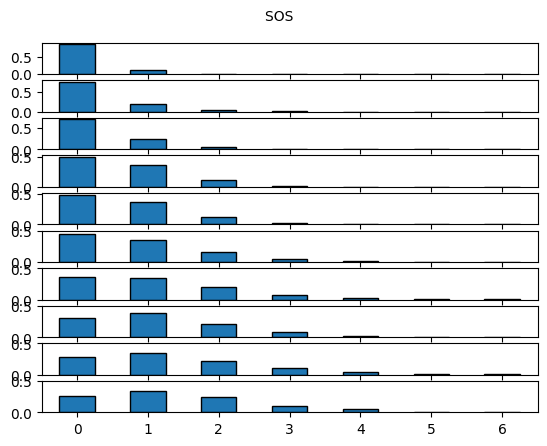

In [ ]:
# SOS distributions

fig, axes = plt.subplots(nrows=len(pval), ncols=1, sharex=True) #, figsize=(4, 12))


bound = 7
width = 0.5  # adjusted width for  centering
area_value = 1

# Define bins centered over integer values
bins = np.arange(bound + 1) - 0.5 * width  # Centered bin edges

for i in range(len(traj)):
    s= snames[1]
    axes[i].hist(traj[i][s], bins=bins, density=True, align='mid', width=width, edgecolor='black')
    # Set x and y limits to ensure consistent view
    axes[i].set_xlim(-0.5, bound - 0.5)
    #axes[i - 1].set_ylim(0, 0.8)
    axes[i].set_xticks(np.arange(0, bound, 1))
    axes[i].set_yticks(np.arange(0, 1, 0.5))
fig.suptitle("SOS ", fontsize=10, y=0.95)


## Plot combined figure (time course, activated RasGTP, and SOS bound)

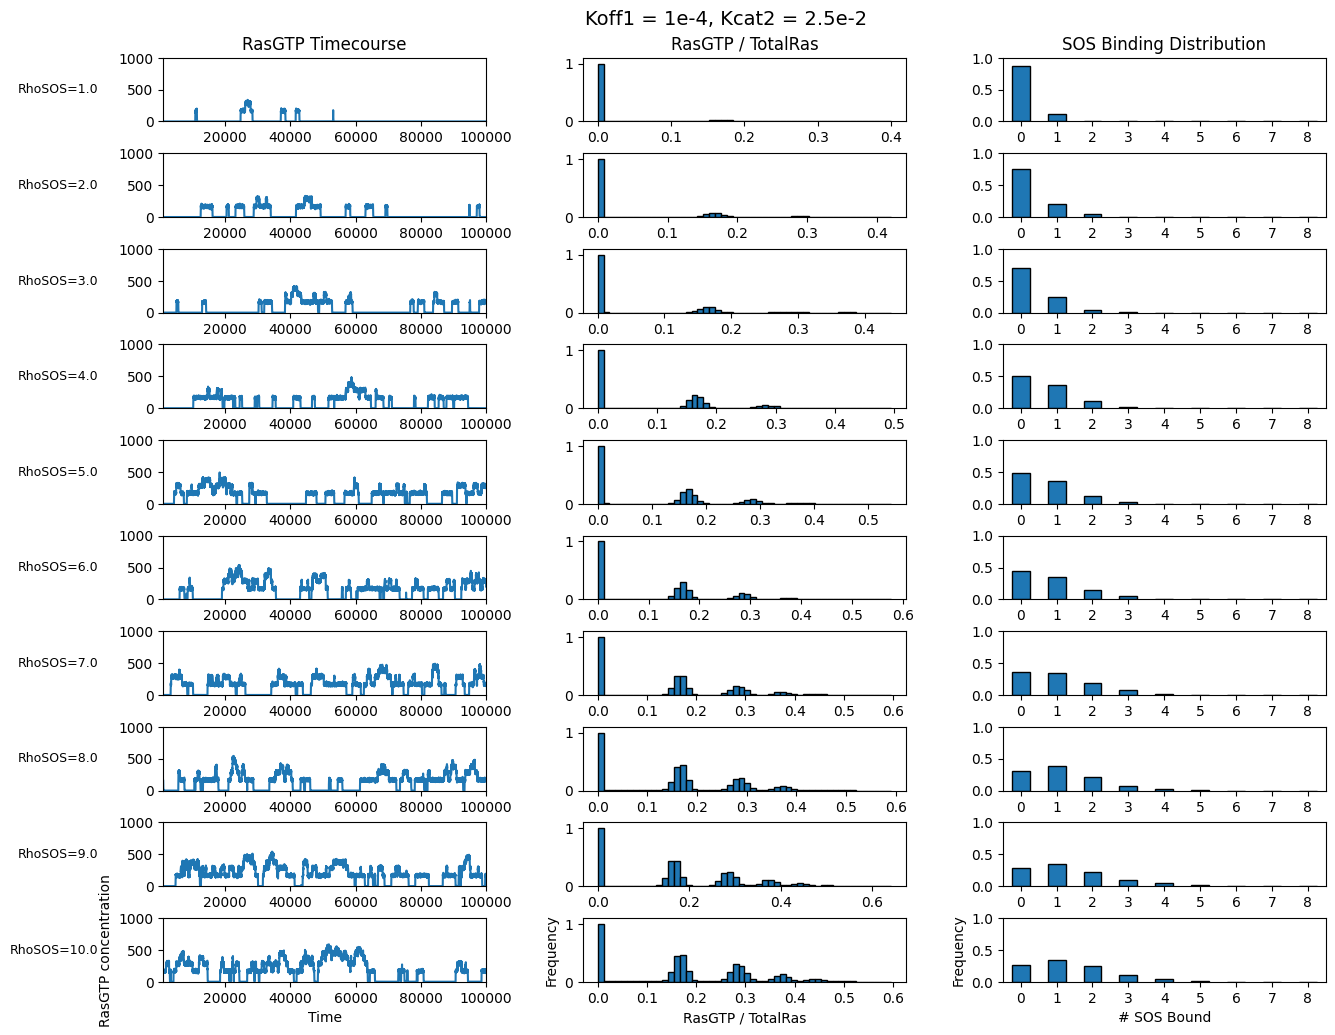

In [ ]:
### plot all 3 in same figure 

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(len(pval), 3, wspace=0.3, hspace=0.5)

# constants for histogram bins
bound = 9
width = 0.5
bins_sos = np.arange(bound + 1) - 0.5 * width
xticks_sos = np.arange(0, bound, 1)
yticks_sos = np.arange(0, 1.1, 0.5)

for i in range(len(pval)):
    # --- Activation Plot (RasGTP timecourse) ---
    ax1 = fig.add_subplot(gs[i, 0])
    ax1.plot(traj[i]['time'], traj[i]['totalRasGTP'], color='C0')
    ax1.set_xlim(1000, 100000)
    ax1.set_ylim(0, 1000)

    if i == len(pval) - 1:
        ax1.set_xlabel('Time')
        ax1.set_ylabel('RasGTP concentration')
    else:
        ax1.set_ylabel('')

    # add RhoSOS label to the left of the first column for all 
    ax1.text(-0.2, 0.5, f'RhoSOS={pval[i]}', transform=ax1.transAxes,
             va='center', ha='right', fontsize=9)

    if i == 0:
        ax1.set_title('RasGTP Timecourse')

    # --- Activated RasGTP  Histogram ---
    ax2 = fig.add_subplot(gs[i, 1])
    ras_ratio = traj[i]['totalRasGTP'] / traj[i]['TotalRas']
    counts, bins = np.histogram(ras_ratio, bins=50)
    counts = counts / counts.max()  # mormalize to max height = 1
    ax2.bar(bins[:-1], counts, width=np.diff(bins), edgecolor='black', align='edge')
    ax2.set_ylim(0, 1.1)

    if i == len(pval) - 1:
        ax2.set_xlabel('RasGTP / TotalRas')
        ax2.set_ylabel('Frequency')
    else:
        ax2.set_ylabel('')

    if i == 0:
        ax2.set_title('RasGTP / TotalRas')

    # --- SOS Binding Histogram ---
    ax3 = fig.add_subplot(gs[i, 2])
    ax3.hist(traj[i]['totalBoundRas'], bins=bins_sos, density=True, align='mid',
             width=width, edgecolor='black')
    ax3.set_xlim(-0.5, bound - 0.5)
    ax3.set_ylim(0, 0.8)
    ax3.set_xticks(xticks_sos)
    ax3.set_yticks(yticks_sos)

    if i == len(pval) - 1:
        ax3.set_xlabel('# SOS Bound')
        ax3.set_ylabel('Frequency')
    else:
        ax3.set_ylabel('')

    if i == 0:
        ax3.set_title('SOS Binding Distribution')

# title for entire figure 
fig.suptitle( 'Koff1 = 1e-4, Kcat2 = 2.5e-2', fontsize=14, y=.92)
plt.show()


## Plot # SOS bound with Activated RasGTP 

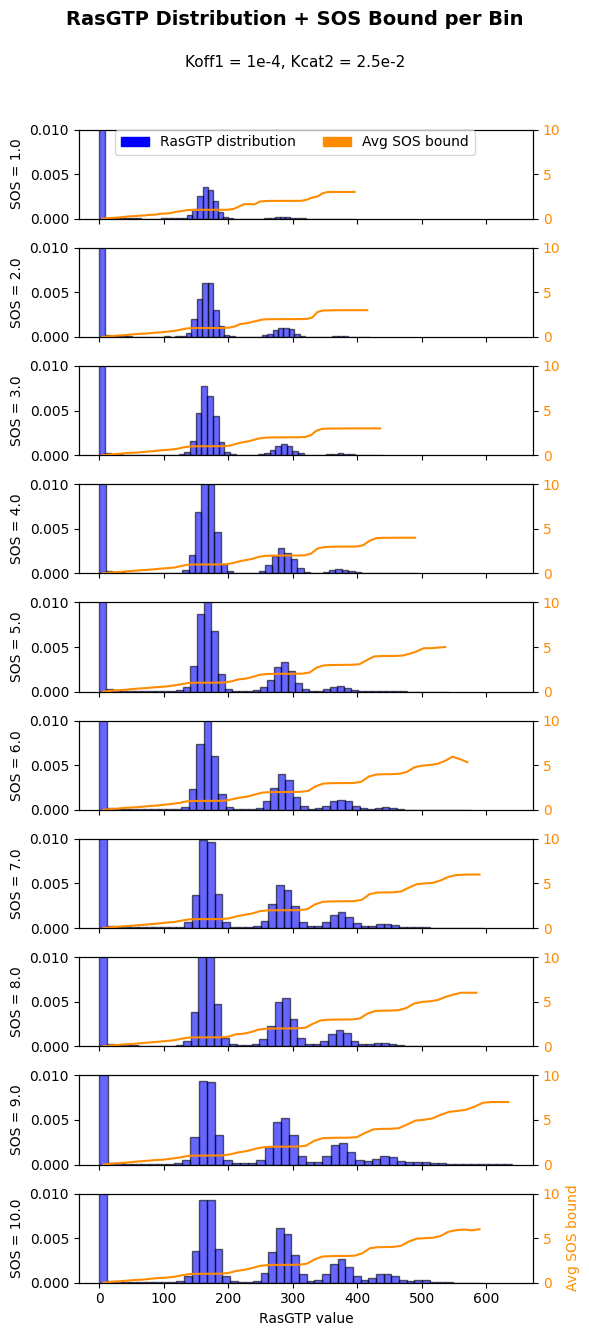

In [ ]:
import matplotlib.patches as mpatches

# combined RasGTP + SOS Bound on same plot 
fig, axes = plt.subplots(nrows=len(pval), ncols=1, sharex=True, figsize=(6, 14))

# make main title higher above
fig.subplots_adjust(top=0.88, hspace=0.4)

fig.text(0.5, 0.94, "RasGTP Distribution + SOS Bound per Bin", ha='center', fontsize=14, weight='bold')
fig.text(0.5, 0.91, "Koff1 = 1e-4, Kcat2 = 2.5e-2", ha='center', fontsize=11)

# legend for colors 
legend_handles = [
    mpatches.Patch(color='blue', label='RasGTP distribution'),
    mpatches.Patch(color='darkorange', label='Avg SOS bound'),
]
fig.legend(handles=legend_handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.87), fontsize=10)

# each subplot
for i in range(len(traj)):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    ras = traj[i][snames[0]]
    sos = traj[i][snames[1]]
    
    # rasGTP histogram 
    ax1.hist(ras, bins=50, density=True, align='mid', edgecolor='black',
             alpha=0.6, color='blue')
    ax1.set_ylim(0, 0.01)
    ax1.set_ylabel(f'SOS = {pval[i]:.1f}', color='black')

    # bin and plot SOS mean
    bins = np.linspace(min(ras), max(ras), 50)
    sos_mean = []
    for j in range(len(bins) - 1):
        in_bin = (ras >= bins[j]) & (ras < bins[j + 1])
        sos_avg = np.mean(sos[in_bin]) if np.any(in_bin) else np.nan
        sos_mean.append(sos_avg)

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    ax2.plot(bin_centers, sos_mean, color='darkorange', linewidth=1.5)
    ax2.tick_params(axis='y', labelcolor='darkorange')

    #  y-axis range for average SOS bound (0 to 10)
    ax2.set_ylim(0, 10)

    if i == 9: 
        ax2.set_ylabel('Avg SOS bound', color='darkorange')

axes[-1].set_xlabel('RasGTP value')
#axes[-1].set_ylabel('RasGTP Level Frequency')
plt.tight_layout(rect=[0, 0, 1, 0.88])


## Bifurcation Plot 

In [1]:
# bifurcation plot 


import numpy as np
import matplotlib.pyplot as plt
import bionetgen


# load and prepare model
model = "updatedSOSRasModel"
model = bionetgen.bngmodel(model + ".bngl")
sim = model.setup_simulator()
sim.setIntegrator('cvode')  #  deterministic ODE solver


snames = ['totalRasGTP', 'totalBoundRas', 'TotalRas']
sim.selections = snames
Kon = 7e-8



# Define parameter range
pval_forward = np.linspace(1, 10, 100)
pval_backward = pval_forward[::-1]

# Containers for results
ras_fwd = []
ras_bwd = []

# forward 
for p in pval_forward:
    sim.RhoSOS = p
    sim.Kon1 = p * Kon
    sim.Kon2 = p * Kon
    sim.reset()
    result = sim.simulate(0, 1000000, 1000000)
    ras_fwd.append(result[-1, 0])

# backward 
for p in pval_backward:
    sim.RhoSOS = p
    sim.Kon1 = p * Kon
    sim.Kon2 = p * Kon
    sim.reset()
    result = sim.simulate(0, 1000000, 1000000)
    ras_bwd.append(result[-1, 0])

# Plotting
plt.plot(pval_forward, ras_fwd, label='Forward', color='C0', linewidth=2)
plt.plot(pval_backward, ras_bwd, label='Backward', color='C1', linewidth=2)

plt.xlabel('RhoSOS')
plt.ylabel('Total RasGTP concentration ')
#plt.title('Multimodal Bifurcation Plot')
plt.title('Revised Bifurcation Plot')
plt.ylim(0, 1000)
plt.legend()
plt.grid(True)
plt.show()



BNGModelError: There was an issue with BNGL model: updatedSOSRasModel.bngl
XML file couldn't be generated